In [1]:
import sys
sys.path.append('/home/victorialena/rlkit')

import pdb
import matplotlib.pyplot as plt
import rlkit
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch_geometric

from argparse import ArgumentParser
from matplotlib import animation
from matplotlib.animation import FuncAnimation, PillowWriter 
from torch.optim import Adam
from torch_geometric.data import Data

from actor.drone_discrete import *
from env.drone_delivery import *
from path_collector import MdpPathCollector
from policies import argmaxDiscretePolicy, epsilonGreedyPolicy
from replay_buffer import anyReplayBuffer

In [2]:
# ------------------ Helpers

def mean_reward_per_traj(paths):
    return np.mean([torch.vstack(p['rewards']).sum().item() for p in paths])

def mean_reward(paths):
    return np.hstack([torch.vstack(p['rewards']).sum(1).numpy() for p in paths]).mean()

def max_reward_per_traj(paths):
    return np.mean([torch.vstack(p['rewards']).sum(1).max().item() for p in paths])

def get_success_rate(paths):
    success = [p['terminals'][-1].item() for p in paths]
    return sum(success)/len(paths)

# def max_reward(paths):
#     return np.hstack([torch.vstack(p['rewards']).sum(1).numpy() for p in paths]).max()

def printSettings(args):
    print(args, '\n')
    
def make_plot(avg_r_train, avg_r_test, n_iter, n_epoch, baselines, saveas=""):
    for b, col, name in zip(baselines, 
                            ['lightgray', 'darkgray', 'gray'], 
                            ['random', 'closest', 'pre-assigned']):
        plt.plot(np.arange(n_iter*n_epoch), [b]*(n_iter*n_epoch), label=name, color=col)

    plt.plot(np.arange(n_iter*n_epoch), avg_r_train, label = "avg R (train)")
    plt.plot(np.arange(n_iter, n_iter*n_epoch+1, step=n_iter), avg_r_test, label = "avg R (test)")
    plt.legend()
    
    if saveas:
        plt.savefig("figs/drone_delivery/"+saveas+".png", dpi=300)
    else:
        plt.show()

def simple_animation(env, obs, saveas='animation_1'):
    fig, ax = plt.subplots(figsize=(6,4))    
    
    def env_simple_update(num, obs, ax):
        ax.clear()
        env.render(obs[num])
        ax.set_title("Frame {}".format(num))
    
    ani = animation.FuncAnimation(fig, env_simple_update, frames=len(obs), fargs=(obs, ax))
    ani.save("figs/drone_delivery/"+saveas+'.gif', writer='imagemagick', savefig_kwargs={'facecolor':'white'}, fps=1)

In [3]:
class Args():
    def __init__(self):
        self.seed = 0
        self.c_hidden = [64, 16]
        self.n_linear = 1
        self.eps = 0.1 #0.5
        self.sim_annealing_fac = 1.0 #.9
        self.replay_buffer_cap = 10000
        self.n_samples = 64
        self.prioritized_replay = True
        self.learning_rate = 1E-3
        self.n_epoch = 100 #15
        self.n_iter = 128 #256
        self.batch_size = 64
        self.gamma = 0.9
        self.dropout = 0.0

        self.graph_type = "sparse"
        self.load_from = "gat08v30"
        self.save_to = ""
        self.plot = True
        self.plot_name = ""
        self.max_sample_distance = 1

        self.maze_size = 10 #5
        self.ndrones = 4 #1
        self.ngoals = 2 #1

In [4]:
def print_path(p):
    for s, a, r, t in zip(p['observations'], p['actions'], p['rewards'], p['terminals']):
        print(s.x)
        print(a)
        print(r)
        print(t)
        print('\n')

In [5]:
def print_random_path(p):
    idx = np.random.randint(len(p))
    print_path(p[idx])

In [6]:
args = Args()
device = 'cpu' #torch.cuda.current_device() if torch.cuda.is_available() else 'cpu'

env = droneDelivery(args, device=device)
x = env.reset()

In [7]:
in_channels, out_channels = env.get_channels()

torch.manual_seed(args.seed)
np.random.seed(args.seed)
env.seed(args.seed)

qf = droneDeliveryModel(in_channels, out_channels, args.c_hidden, n_linear=args.n_linear, 
                        bounds=env.get_size(), dropout=args.dropout)
qf.load_state_dict(torch.load("chkpt/"+args.load_from+".pt"))
;

''

In [8]:
qf.train(False)
eval_policy = argmaxDiscretePolicy(qf)

In [9]:
eval_path_collector = MdpPathCollector(env, eval_policy)
paths = eval_path_collector.collect_new_paths(128, 14, False)

In [10]:
get_success_rate(paths)

0.8125

In [11]:
print_path(paths[0])

tensor([[ 7.,  3., -1.,  1.],
        [ 5.,  3., -1.,  1.],
        [ 6.,  4., -1.,  1.],
        [ 5.,  1., -1.,  1.],
        [ 4.,  1.,  1.,  1.],
        [ 6.,  3.,  1.,  3.]])
tensor([1, 3, 3, 1])
tensor([-0.0025, -0.0025, -0.0025, -0.0025])
tensor(False)


tensor([[ 6.,  3., -1.,  1.],
        [ 5.,  2., -1.,  1.],
        [ 6.,  3., -1.,  1.],
        [ 4.,  1., -1.,  1.],
        [ 4.,  1.,  1.,  1.],
        [ 6.,  3.,  1.,  3.]])
tensor([4, 3, 4, 4])
tensor([ 0.9500, -0.0050,  0.9500,  1.0000])
tensor(False)


tensor([[ 6.,  3., -1.,  0.],
        [ 5.,  1., -1.,  1.],
        [ 6.,  3., -1.,  0.],
        [ 4.,  1., -1.,  0.],
        [ 4.,  1.,  1.,  0.],
        [ 6.,  3.,  1.,  1.]])
tensor([4, 0, 4, 4])
tensor([-0.0500, -0.0025, -0.0500,  0.0000])
tensor(False)


tensor([[ 6.,  3., -1.,  0.],
        [ 6.,  1., -1.,  1.],
        [ 6.,  3., -1.,  0.],
        [ 4.,  1., -1.,  0.],
        [ 4.,  1.,  1.,  0.],
        [ 6.,  3.,  1.,  1.]])
tensor([4, 2, 4, 4])
tensor([-

#### record sample traj

In [17]:
from argparse import ArgumentParser
from matplotlib import animation
from matplotlib.animation import FuncAnimation, PillowWriter 

In [36]:
def simple_animation(obs, lim, saveas='sample_trajectory'):
    fig, ax = plt.subplots(figsize=(6,6)) #,axis=equal)
    # image_path = get_sample_data('ada.png')
    
    def env_simple_update(num, obs, ax):
        ax.clear()
        for agent in obs[num].x.flip(0):
            color = "g" if agent[-2] > 0 else ("y" if agent[-1] == 0 else 'tab:orange')
            plt.plot(agent[0], agent[1], color=color, marker='o', markersize=15*abs(agent[-1]))
        ax.set_title("Frame {}".format(num))
        ax.set_xlim(lim)
        ax.set_ylim(lim)
    
    ani = animation.FuncAnimation(fig, env_simple_update, frames=len(obs), fargs=(obs, ax))
    ani.save("figs/collision_avoidance/"+saveas+'.gif', writer='imagemagick', savefig_kwargs={'facecolor':'white'}, fps=1)

MovieWriter imagemagick unavailable; using Pillow instead.


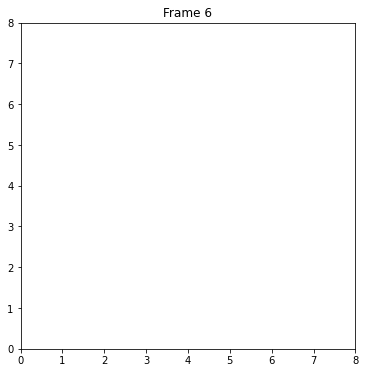

In [37]:
simple_animation(paths[0]['observations'], [0, 8])

In [ ]:
# python run_drone_delivery.py --ndrones 2 --ngoals 2 --gamma 0.9 --maze_size 8 --n_epoch 500 --graph_type sparse --c_hidden 64 16 --n_linear 1 --plot_name gat08v22_2 --load_from gat08v22 --save_to gat08v22_2